In [ ]:
import wandb
wandb.login(key="")

True

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import wandb

api = wandb.Api()
project = "justinshenk-time/lt_st_attribution_comparision"

def load_run_history(run_name):
    runs = api.runs(project, filters={"display_name": run_name})
    run = next(iter(runs))
    history = run.history(pandas=True)
    return history

st = load_run_history("ST")
lt = load_run_history("LT")

# Parse component columns into tidy format
def tidy(df, label):
    meta_cols = ["_step", "_runtime", "_timestamp", "num_steps"]
    comp_cols = [c for c in df.columns if c not in meta_cols]
    row = df[comp_cols].iloc[0]
    records = []
    for col, val in row.items():
        parts = col.split("/")
        comp_type = parts[0]   # attn, mlp, layer_out
        layer = int(parts[1])
        records.append({"component": comp_type, "layer": layer, "score": val, "condition": label})
    return pd.DataFrame(records)

st_tidy = tidy(st, "ST (short-term)")
lt_tidy = tidy(lt, "LT (long-term)")
df = pd.concat([st_tidy, lt_tidy], ignore_index=True)

print(df.groupby(["condition","component"])["score"].describe())


                           count      mean       std       min           25%  \
condition       component                                                      
LT (long-term)  attn        28.0 -0.000068  0.000200 -0.000870 -6.651878e-05   
                layer_out   28.0 -0.000726  0.000196 -0.001114 -7.829666e-04   
                mlp         28.0 -0.000049  0.000148 -0.000299 -1.277924e-04   
ST (short-term) attn        28.0  0.000042  0.000140 -0.000420 -3.762543e-07   
                layer_out   28.0  0.000327  0.000208 -0.000078  1.807213e-04   
                mlp         28.0  0.000001  0.000258 -0.001175 -3.904104e-05   

                                50%           75%       max  
condition       component                                    
LT (long-term)  attn      -0.000015  2.607703e-05  0.000110  
                layer_out -0.000694 -5.998611e-04 -0.000441  
                mlp       -0.000072 -4.768372e-07  0.000326  
ST (short-term) attn       0.000025  8.726120e-05

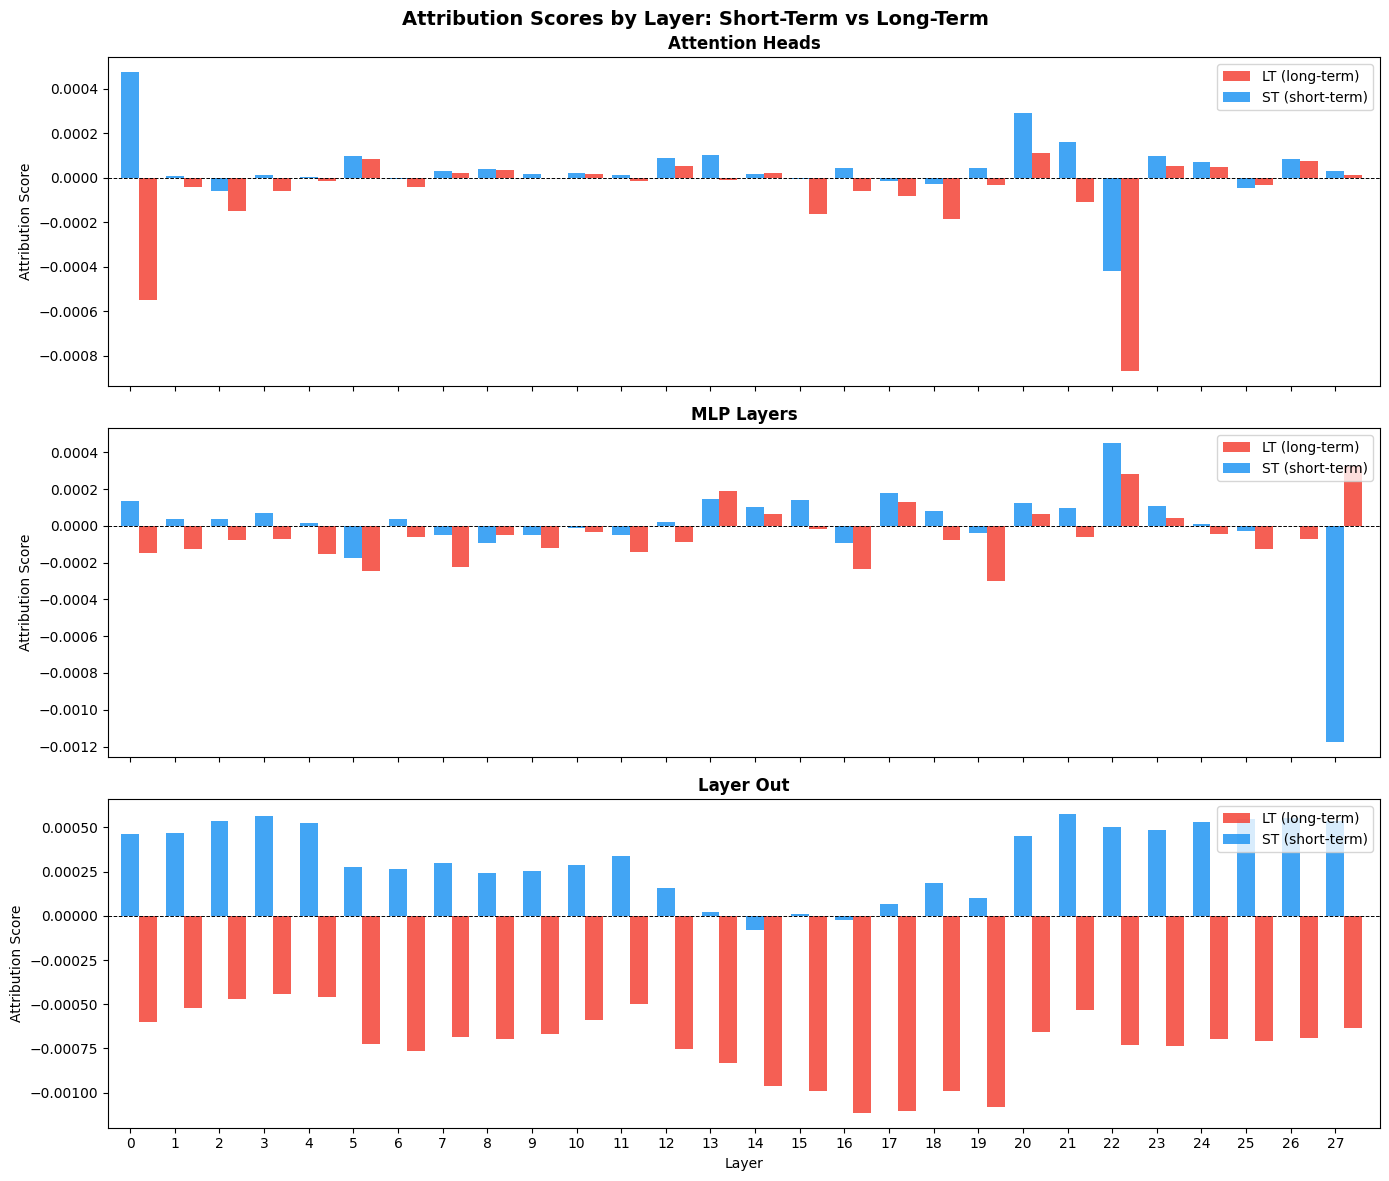

In [17]:

# ── Figure 1: Attribution scores per layer, split by component type ──────────
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
components = ["attn", "mlp", "layer_out"]
titles = ["Attention Heads", "MLP Layers", "Layer Out"]
colors = {"ST (short-term)": "#2196F3", "LT (long-term)": "#F44336"}

for ax, comp, title in zip(axes, components, titles):
    sub = df[df["component"] == comp]
    for cond, grp in sub.groupby("condition"):
        grp_sorted = grp.sort_values("layer")
        ax.bar(grp_sorted["layer"] + (0 if "ST" in cond else 0.4),
               grp_sorted["score"], width=0.4,
               color=colors[cond], label=cond, alpha=0.85)
    ax.axhline(0, color="black", linewidth=0.7, linestyle="--")
    ax.set_ylabel("Attribution Score")
    ax.set_title(title, fontweight="bold")
    ax.legend(loc="upper right")
    ax.set_xlim(-0.5, 28)

axes[-1].set_xlabel("Layer")
axes[-1].set_xticks(range(28))
plt.suptitle("Attribution Scores by Layer: Short-Term vs Long-Term", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()


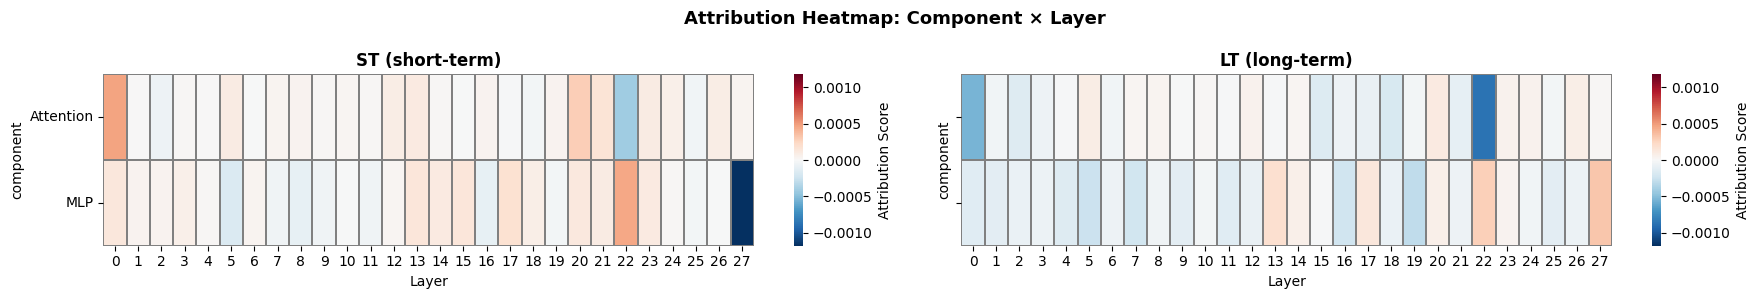

In [10]:

# ── Figure 2: Heatmap — layer × component for each condition ─────────────────
def make_heatmap_matrix(tidy_df):
    pivot = tidy_df.pivot_table(index="component", columns="layer", values="score", aggfunc="first")
    pivot = pivot.reindex(["attn", "mlp"])
    return pivot

sub_df = df[df["component"] != "layer_out"]
lim = max(abs(sub_df["score"].min()), abs(sub_df["score"].max()))

fig, axes = plt.subplots(1, 2, figsize=(18, 3), sharey=True)
for ax, (cond, sub) in zip(axes, [("ST (short-term)", st_tidy), ("LT (long-term)", lt_tidy)]):
    mat = make_heatmap_matrix(sub)
    sns.heatmap(mat, ax=ax, cmap="RdBu_r", center=0, vmin=-lim, vmax=lim,
                linewidths=0.3, linecolor="grey", cbar_kws={"label": "Attribution Score"})
    ax.set_title(cond, fontweight="bold")
    ax.set_xlabel("Layer")
    ax.set_yticklabels(["Attention", "MLP"], rotation=0)

plt.suptitle("Attribution Heatmap: Component × Layer", fontsize=13, fontweight="bold")
plt.tight_layout()
plt.show()


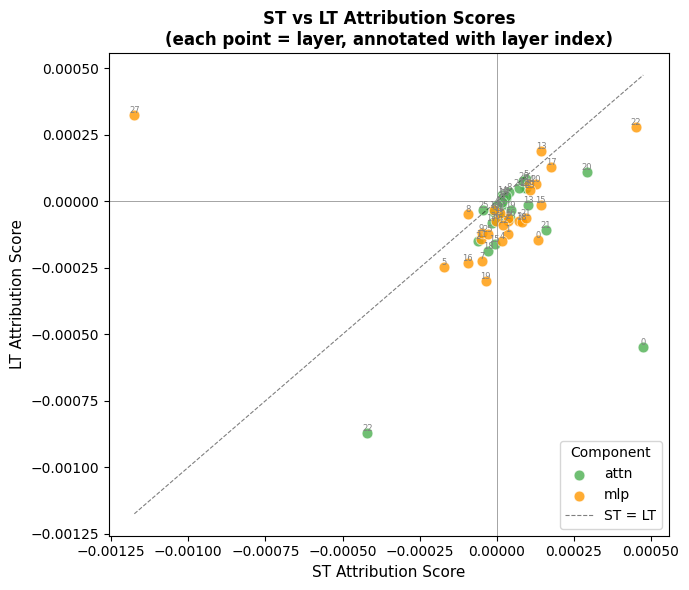

In [11]:

# ── Figure 3: ST vs LT scatter (attn + mlp only) ────────────────────────────
merged = st_tidy.merge(lt_tidy, on=["component", "layer"], suffixes=("_st", "_lt"))
merged = merged[merged["component"] != "layer_out"]

fig, ax = plt.subplots(figsize=(7, 6))
comp_colors = {"attn": "#4CAF50", "mlp": "#FF9800"}

for comp, grp in merged.groupby("component"):
    ax.scatter(grp["score_st"], grp["score_lt"],
               c=comp_colors[comp], label=comp, s=60, alpha=0.8, edgecolors="white", linewidths=0.5)
    for _, row in grp.iterrows():
        ax.annotate(str(int(row["layer"])), (row["score_st"], row["score_lt"]),
                    fontsize=6, color="grey", ha="center", va="bottom")

lims = [min(merged[["score_st","score_lt"]].min()), max(merged[["score_st","score_lt"]].max())]
ax.plot(lims, lims, "k--", linewidth=0.8, alpha=0.5, label="ST = LT")
ax.axhline(0, color="grey", linewidth=0.5)
ax.axvline(0, color="grey", linewidth=0.5)
ax.set_xlabel("ST Attribution Score", fontsize=11)
ax.set_ylabel("LT Attribution Score", fontsize=11)
ax.set_title("ST vs LT Attribution Scores\n(each point = layer, annotated with layer index)", fontsize=12, fontweight="bold")
ax.legend(title="Component")
plt.tight_layout()
plt.show()


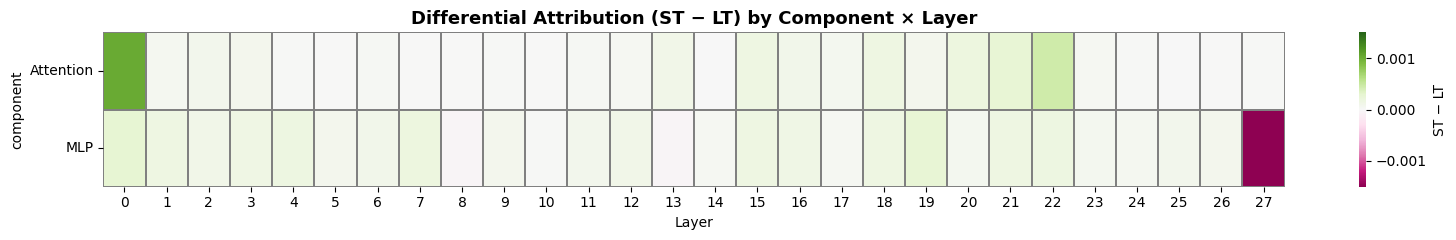


Top 10 components by |ST − LT|:
component  layer  score_st  score_lt     delta
      mlp     27 -0.001175  0.000326 -0.001501
     attn      0  0.000475 -0.000549  0.001024
     attn     22 -0.000420 -0.000870  0.000450
      mlp      0  0.000134 -0.000146  0.000279
     attn     21  0.000159 -0.000108  0.000268
      mlp     19 -0.000036 -0.000299  0.000263
     attn     20  0.000292  0.000110  0.000182
      mlp      7 -0.000047 -0.000224  0.000177
      mlp     22  0.000450  0.000280  0.000170
      mlp      4  0.000017 -0.000151  0.000168


In [12]:

# ── Figure 4: Difference heatmap (ST - LT, attn + mlp only) ─────────────────
diff = merged.copy()
diff["delta"] = diff["score_st"] - diff["score_lt"]
pivot_diff = diff.pivot_table(index="component", columns="layer", values="delta")
pivot_diff = pivot_diff.reindex(["attn", "mlp"])

fig, ax = plt.subplots(figsize=(16, 2.5))
lim = pivot_diff.abs().max().max()
sns.heatmap(pivot_diff, ax=ax, cmap="PiYG", center=0, vmin=-lim, vmax=lim,
            linewidths=0.3, linecolor="grey",
            cbar_kws={"label": "ST − LT"})
ax.set_title("Differential Attribution (ST − LT) by Component × Layer",
             fontsize=13, fontweight="bold")
ax.set_xlabel("Layer")
ax.set_yticklabels(["Attention", "MLP"], rotation=0)
plt.tight_layout()
plt.show()

top = diff.reindex(diff["delta"].abs().sort_values(ascending=False).index).head(10)
print("\nTop 10 components by |ST − LT|:")
print(top[["component","layer","score_st","score_lt","delta"]].to_string(index=False))


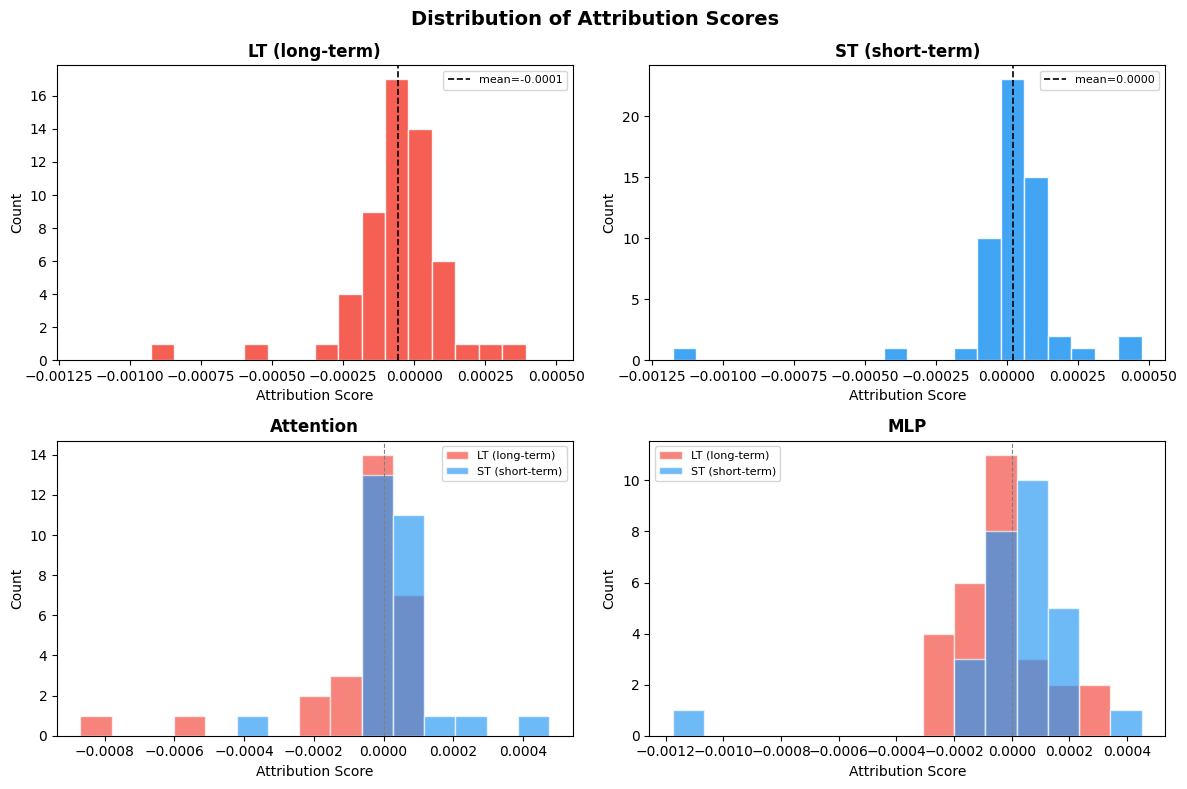

In [13]:

# ── Figure 5: Histograms of attribution scores ───────────────────────────────
plot_df = df[df["component"] != "layer_out"]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

colors = {"ST (short-term)": "#2196F3", "LT (long-term)": "#F44336"}
comp_labels = {"attn": "Attention", "mlp": "MLP"}

# Row 0: per-condition histograms (all attn+mlp scores pooled)
# Shared bins across both conditions
pooled_min = plot_df["score"].min()
pooled_max = plot_df["score"].max()
pooled_bins = np.linspace(pooled_min, pooled_max, 21)  # 20 bins

for ax, (cond, grp) in zip(axes[0], plot_df.groupby("condition")):
    ax.hist(grp["score"], bins=pooled_bins, color=colors[cond], edgecolor="white", alpha=0.85)
    ax.axvline(grp["score"].mean(), color="black", linewidth=1.2, linestyle="--", label=f"mean={grp['score'].mean():.4f}")
    ax.set_title(cond, fontweight="bold")
    ax.set_xlabel("Attribution Score")
    ax.set_ylabel("Count")
    ax.legend(fontsize=8)

# Row 1: per-component overlapping histograms (ST vs LT)
# Shared bins computed from the union of both conditions per component
for ax, comp in zip(axes[1], ["attn", "mlp"]):
    comp_data = plot_df[plot_df["component"] == comp]
    comp_min = comp_data["score"].min()
    comp_max = comp_data["score"].max()
    comp_bins = np.linspace(comp_min, comp_max, 16)  # 15 bins

    for cond, grp in comp_data.groupby("condition"):
        ax.hist(grp["score"], bins=comp_bins, color=colors[cond], edgecolor="white",
                alpha=0.65, label=cond)
    ax.axvline(0, color="grey", linewidth=0.8, linestyle="--")
    ax.set_title(comp_labels[comp], fontweight="bold")
    ax.set_xlabel("Attribution Score")
    ax.set_ylabel("Count")
    ax.legend(fontsize=8)

plt.suptitle("Distribution of Attribution Scores", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()
